In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#-- NBA API Modules --#

from nba_api.stats.endpoints import boxscoretraditionalv2
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams 

import time


In [2]:
teams = teams.get_teams()
GSW = [x for x in teams if x['full_name'] == 'Golden State Warriors'][0]
GSW_id = GSW['id']

In [3]:
GSW_GLDATA = teamgamelog.TeamGameLog(team_id = GSW_id, season = '2021', season_type_all_star = 'Playoffs'
                                     ).get_data_frames()[0]
GSW_GAMEID = GSW_GLDATA['Game_ID'].tolist()
GSW_GLDATA.head(5)

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612744,0042100406,"JUN 16, 2022",GSW @ BOS,W,4,2,0.667,240,38,...,1.000,15,29,44,27,13,7,15,20,103
1,1610612744,0042100405,"JUN 13, 2022",GSW vs. BOS,W,3,2,0.600,240,41,...,0.867,4,35,39,23,9,2,6,28,104
2,1610612744,0042100404,"JUN 10, 2022",GSW @ BOS,W,2,2,0.500,240,40,...,0.800,16,39,55,20,10,5,16,21,107
3,1610612744,0042100403,"JUN 08, 2022",GSW @ BOS,L,1,2,0.333,240,36,...,0.867,6,25,31,22,7,5,16,23,100
4,1610612744,0042100402,"JUN 05, 2022",GSW vs. BOS,W,1,1,0.500,240,39,...,0.700,6,36,42,25,15,2,12,17,107


In [4]:
### Data Retrieval & Cleanup ###

bxdata = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = GSW_GAMEID[0]).get_data_frames()[0]

### Selecting only GSW Players who were eligible to play ###
bxdata = bxdata.loc[(bxdata['TEAM_ID'] == GSW_id) & (bxdata['COMMENT'].str.contains('DNP - Injury/Illness') == False)].reset_index(drop = True)

### Fill all NaN values with 0 ###
bxdata = bxdata.fillna(0)

In [6]:
### Create a value for time in minutes ###
bxdata['MINUTES'] = bxdata['MIN'].str.split(':', expand = True).fillna(0)[0].astype(float)
bxdata['SECONDS'] = bxdata['MIN'].str.split(':', expand = True).fillna(0)[1].astype(float)
bxdata['TIME'] = bxdata['MINUTES'] + bxdata['SECONDS'] / 60

bxdata[['MIN', 'MINUTES', 'SECONDS', 'TIME']].head(5)

,MIN,MINUTES,SECONDS,TIME
0,43.000000:41,43.0,41.0,43.683333
1,13.000000:03,13.0,3.0,13.050000
2,41.000000:49,41.0,49.0,41.816667
3,41.000000:18,41.0,18.0,41.300000
4,39.000000:55,39.0,55.0,39.916667


In [7]:
### Basic Share Calculations ###
bxdata['TIMESHARE'] = bxdata['TIME'] / bxdata['TIME'].sum()
bxdata['PTSSHARE'] = bxdata['PTS'] / bxdata['PTS'].sum()

### Point Capitalization ###
bxdata['PTSCAP'] = bxdata['TIME'] * bxdata['PTS']
bxdata['PTSCAPSHARE'] = bxdata['PTSCAP'] / bxdata['PTSCAP'].sum()

### Output Check ###
bxdata = bxdata[[
            'PLAYER_NAME'
            , 'TIME'
            , 'TIMESHARE'
            , 'PTS'
            , 'PTSSHARE'
            , 'PTSCAP'
            , 'PTSCAPSHARE'
        ]]

In [8]:
### HHI Index Calculations ###
print('HHI Index of Time Share: ' + str(round((bxdata['TIMESHARE']**2).sum(), 2)))
print('HHI Index of Points Share: ' + str(round((bxdata['PTSSHARE']**2).sum(), 2)))
print('HHI Index of Points Capitalization Share: ' + str(round((bxdata['PTSCAPSHARE']**2).sum(), 2)))

HHI Index of Time Share: 0.14
HHI Index of Points Share: 0.19
HHI Index of Points Capitalization Share: 0.23


In [10]:
bxsdata = pd.DataFrame()

HHI_TS_INDEX = []
HHI_PS_INDEX = []
HHI_PCS_INDEX = []

### All Games Loop ###

for i in range(0, len(GSW_GAMEID)):

    ### Data Retrieval & Cleanup ###
    bxdata = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = GSW_GAMEID[i]).get_data_frames()[0]

    ### Selecting only GSW Players who were eligible to play ###
    bxdata = bxdata.loc[(bxdata['TEAM_ID'] == GSW_id) & (bxdata['COMMENT'].str.contains('DNP - Injury/Illness') == False)].reset_index(drop = True)

    ### Fill all NaN values with 0 ###
    bxdata = bxdata.fillna(0)

    ### Create a value for time in minutes ###
    bxdata['MINUTES'] = bxdata['MIN'].str.split(':', expand = True).fillna(0)[0].astype(float)
    bxdata['SECONDS'] = bxdata['MIN'].str.split(':', expand = True).fillna(0)[1].astype(float)
    bxdata['TIME'] = bxdata['MINUTES'] + bxdata['SECONDS'] / 60

    ### Basic Share Calculations ###
    bxdata['TIMESHARE'] = bxdata['TIME'] / bxdata['TIME'].sum()
    bxdata['PTSSHARE'] = bxdata['PTS'] / bxdata['PTS'].sum()

    ### Point Capitalization ###
    bxdata['PTSCAP'] = bxdata['TIME'] * bxdata['PTS']
    bxdata['PTSCAPSHARE'] = bxdata['PTSCAP'] / bxdata['PTSCAP'].sum()

    ### Game ID Primary Key ###
    bxdata['GAME_ID'] = GSW_GAMEID[i]
    
    ### Output Check ###
    bxdata = bxdata[[
                'GAME_ID'
                , 'PLAYER_NAME'
                , 'TIME'
                , 'TIMESHARE'
                , 'PTS'
                , 'PTSSHARE'
                , 'PTSCAP'
                , 'PTSCAPSHARE'
            ]]

    ### HHI Index Calculations ###
    HHI_TS = ( bxdata['TIMESHARE'] ** 2 ).sum()
    HHI_PS = ( bxdata['PTSSHARE']**2 ).sum()
    HHI_PCS = ( bxdata['PTSCAPSHARE'] ** 2).sum() 

    ### Updating ###
    bxsdata = pd.concat([bxsdata, bxdata])

    HHI_TS_INDEX.append(HHI_TS)
    HHI_PS_INDEX.append(HHI_PS)
    HHI_PCS_INDEX.append(HHI_PCS)

    time.sleep(2)


bxsdata['GAME_ID'] = bxsdata['GAME_ID'].astype(int)
GSW_GLDATA['Game_ID'] = GSW_GLDATA['Game_ID'].astype(int)

bxsdata = bxsdata.join(GSW_GLDATA.set_index('Game_ID')[['GAME_DATE', 'MATCHUP', 'WL', 'W_PCT', 'PTS']]
                , on = 'GAME_ID'        
                , how = 'left'
                , lsuffix = '_TEAM')

### HHI Dataframe ###
HHI_DF = pd.DataFrame([GSW_GAMEID, HHI_TS_INDEX, HHI_PS_INDEX, HHI_PCS_INDEX]).T
HHI_DF.columns = ['GAME_ID', 'HHI_TS', 'HHI_PS', 'HHI_PCS']
HHI_DF['GAME_ID'] = HHI_DF['GAME_ID'].astype(int)
HHI_DF = HHI_DF.set_index('GAME_ID')

### Join Data and Save to CSV ###
bxsdata.join(HHI_DF, on = 'GAME_ID', how = 'left').to_csv('./{}bxsdata_playoffs.csv'.format('GSW_'))

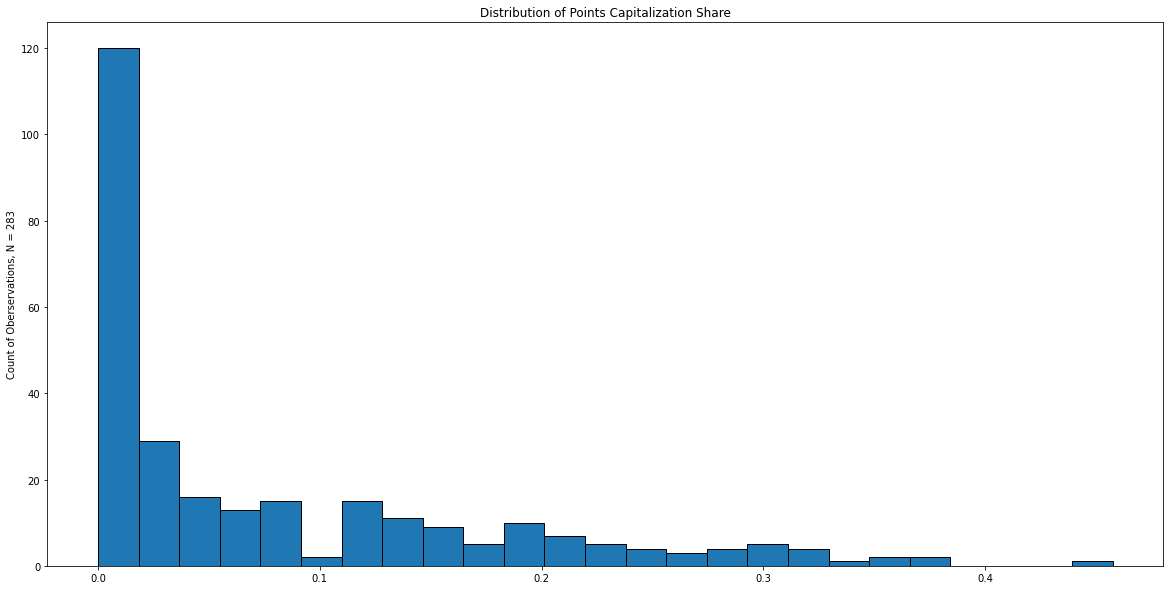

In [11]:
plt.figure(figsize = (20, 10))

#-- Actual plot --#
plt.hist(bxsdata['PTSCAPSHARE'], bins = 25, ec = 'black')

plt.ylabel('Count of Oberservations, N = ' + str(len(bxsdata)))
plt.title('Distribution of Points Capitalization Share')

plt.show()

In [12]:
bxsdata.head()

,GAME_ID,PLAYER_NAME,TIME,TIMESHARE,PTS_TEAM,PTSSHARE,PTSCAP,PTSCAPSHARE,GAME_DATE,MATCHUP,WL,W_PCT,PTS
0,42100406,Andrew Wiggins,43.683333,0.182014,18.0,0.174757,786.300000,0.218143,"JUN 16, 2022",GSW @ BOS,W,0.667,103
1,42100406,Otto Porter Jr.,13.050000,0.054375,6.0,0.058252,78.300000,0.021723,"JUN 16, 2022",GSW @ BOS,W,0.667,103
2,42100406,Draymond Green,41.816667,0.174236,12.0,0.116505,501.800000,0.139214,"JUN 16, 2022",GSW @ BOS,W,0.667,103
3,42100406,Klay Thompson,41.300000,0.172083,12.0,0.116505,495.600000,0.137494,"JUN 16, 2022",GSW @ BOS,W,0.667,103
4,42100406,Stephen Curry,39.916667,0.166319,34.0,0.330097,1357.166667,0.376518,"JUN 16, 2022",GSW @ BOS,W,0.667,103


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


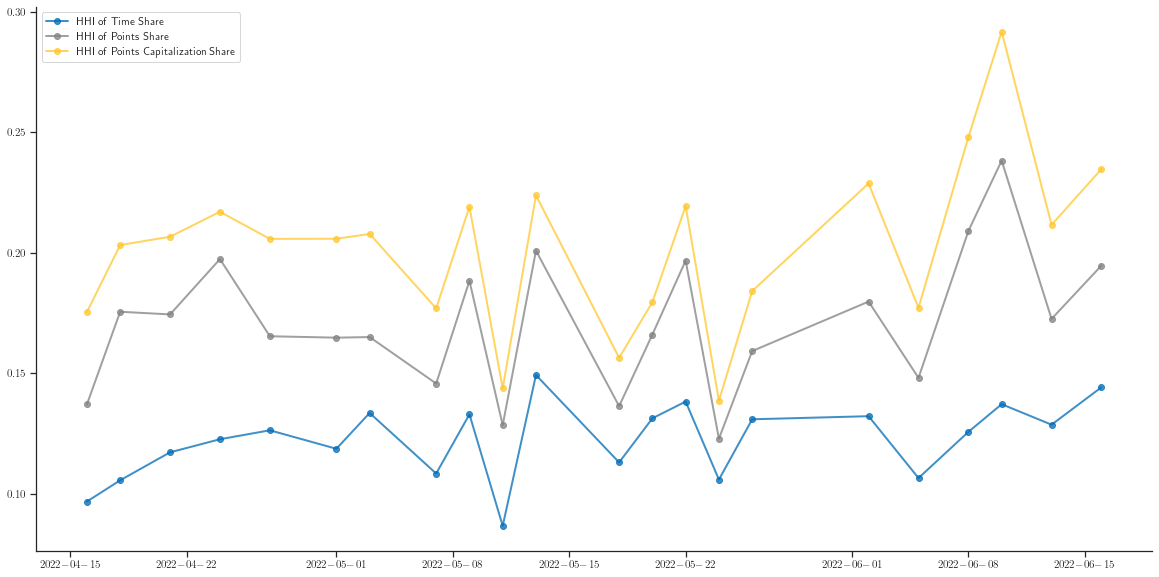

In [15]:
bxsdata['GAME_DATE'] = pd.to_datetime(bxsdata['GAME_DATE'])
wdata = bxsdata.join(HHI_DF, on = 'GAME_ID', how = 'left').pivot_table(
    index = 'GAME_DATE'
    , values = ['HHI_TS', 'HHI_PS', 'HHI_PCS']
    , aggfunc = np.mean)

### HHI Index Plot ###

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

plt.figure(figsize = (20, 10))

import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.plot(wdata['HHI_TS'], linewidth = 2, marker = 'o', color = '#006BB6', alpha = .75)
plt.plot(wdata['HHI_PS'], linewidth = 2, marker = 'o', color = 'grey', alpha = .75)
plt.plot(wdata['HHI_PCS'], linewidth = 2, marker = 'o', color = '#FFC72C', alpha = .75)

plt.legend(labels = ['HHI of Time Share', 'HHI of Points Share', 'HHI of Points Capitalization Share'])

plt.savefig('GSW_HHI_Playoffs.eps', format = 'eps', dpi = 500, bbox_inches = 'tight')
plt.show()

### Memphis Grizzlies

In [174]:
teams = teams.get_teams()

MEM = [x for x in teams if x['full_name'] == 'Memphis Grizzlies'][0]
MEM_id = MEM['id']

MEM_GLDATA = teamgamelog.TeamGameLog(team_id = MEM_id, season = '2022').get_data_frames()[0]
MEM_GAMEID = MEM_GLDATA['Game_ID'].tolist()

MEM_GLDATA

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612763,0022201165,"APR 02, 2023",MEM @ CHI,L,49,29,0.628,240,39,...,0.833,8,39,47,29,1,3,18,22,107
1,1610612763,0022201156,"MAR 31, 2023",MEM vs. LAC,W,49,28,0.636,240,43,...,0.765,12,39,51,25,11,7,14,16,108
2,1610612763,0022201141,"MAR 29, 2023",MEM vs. LAC,L,48,28,0.632,240,49,...,0.821,14,31,45,26,8,4,13,20,132
3,1610612763,0022201133,"MAR 28, 2023",MEM vs. ORL,W,48,27,0.640,240,42,...,0.739,7,42,49,26,11,6,16,17,113
4,1610612763,0022201115,"MAR 26, 2023",MEM @ ATL,W,47,27,0.635,240,48,...,0.737,6,33,39,28,8,7,11,22,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,1610612763,0022200069,"OCT 27, 2022",MEM @ SAC,W,4,1,0.800,240,49,...,0.722,11,32,43,27,5,3,12,18,125
74,1610612763,0022200049,"OCT 24, 2022",MEM vs. BKN,W,3,1,0.750,240,47,...,0.774,12,26,38,21,7,3,8,22,134
75,1610612763,0022200034,"OCT 22, 2022",MEM @ DAL,L,2,1,0.667,240,34,...,0.792,6,23,29,20,4,8,17,29,96
76,1610612763,0022200024,"OCT 21, 2022",MEM @ HOU,W,2,0,1.000,240,45,...,0.690,17,33,50,26,8,10,12,21,129


In [71]:
### Get team ID ###

team_name = 'Los Angeles Lakers'

from nba_api.stats.static import teams 

team_list = teams.get_teams()

NBA_TEAM = [x for x in team_list if x['full_name'] == team_name][0]
NBA_TEAM_id = NBA_TEAM['id']

### Get team game log data ###

### fix the JSONDecodeError: Expecting value: line 1 column 1 (char 0) error ###
NBA_GLDATA = teamgamelog.TeamGameLog(team_id = NBA_TEAM_id, season = '2021').get_data_frames()[0]
NBATEAM_GAMEID = NBA_GLDATA['Game_ID'].tolist()

bxsdata = pd.DataFrame()

HHI_TS_INDEX = []
HHI_PS_INDEX = []
HHI_PCS_INDEX = []

### All Games Loop ###

for i in range(0, len(NBATEAM_GAMEID)):

    ### Data Retrieval & Cleanup ###
    bxdata = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = NBATEAM_GAMEID[i]).get_data_frames()[0]

    ### Selecting only Team Players who were eligible to play ###
    bxdata = bxdata.loc[(bxdata['TEAM_ID'] == NBA_TEAM_id) & (bxdata['COMMENT'].str.contains('DNP - Injury/Illness') == False)].reset_index(drop = True)

    ### Fill all NaN values with 0 ###
    bxdata = bxdata.fillna(0)

    ### Create a value for time in minutes ###
    bxdata['MINUTES'] = bxdata['MIN'].str.split(':', expand = True).fillna(0)[0].astype(float)
    bxdata['SECONDS'] = bxdata['MIN'].str.split(':', expand = True).fillna(0)[1].astype(float)
    bxdata['TIME'] = bxdata['MINUTES'] + bxdata['SECONDS'] / 60

    ### Basic Share Calculations ###
    bxdata['TIMESHARE'] = bxdata['TIME'] / bxdata['TIME'].sum()
    bxdata['PTSSHARE'] = bxdata['PTS'] / bxdata['PTS'].sum()

    ### Point Capitalization ###
    bxdata['PTSCAP'] = bxdata['TIME'] * bxdata['PTS']
    bxdata['PTSCAPSHARE'] = bxdata['PTSCAP'] / bxdata['PTSCAP'].sum()

    ### Game ID Primary Key ###
    bxdata['GAME_ID'] = NBATEAM_GAMEID[i]
    
    ### Output Check ###
    bxdata = bxdata[[
                'GAME_ID'
                , 'TEAM_ID'
                , 'PLAYER_NAME'
                , 'TIME'
                , 'TIMESHARE'
                , 'PTS'
                , 'PTSSHARE'
                , 'PTSCAP'
                , 'PTSCAPSHARE'
            ]]

    ### HHI Index Calculations ###
    HHI_TS = ( bxdata['TIMESHARE'] ** 2 ).sum()
    HHI_PS = ( bxdata['PTSSHARE']**2 ).sum()
    HHI_PCS = ( bxdata['PTSCAPSHARE'] ** 2).sum() 

    ### Updating ###
    bxsdata = pd.concat([bxsdata, bxdata])

    HHI_TS_INDEX.append(HHI_TS)
    HHI_PS_INDEX.append(HHI_PS)
    HHI_PCS_INDEX.append(HHI_PCS)

    time.sleep(2)

### Make Game ID variable an interger for joining compatability ###

bxsdata['GAME_ID'] = bxsdata['GAME_ID'].astype(int)
NBA_GLDATA['Game_ID'] = NBA_GLDATA['Game_ID'].astype(int)
NBA_GLDATA['GAME_DATE'] = pd.to_datetime(NBA_GLDATA['GAME_DATE'])

### Join Game Data to Boxscore Data ###

bxsdata = bxsdata.join(NBA_GLDATA.set_index('Game_ID')[['GAME_DATE', 'MATCHUP', 'WL', 'W_PCT', 'PTS']]
                , on = 'GAME_ID'        
                , how = 'left'
                , lsuffix = '_TEAM')

### HHI Dataframe ###
HHI_DF = pd.DataFrame([NBATEAM_GAMEID, HHI_TS_INDEX, HHI_PS_INDEX, HHI_PCS_INDEX]).T
HHI_DF.columns = ['GAME_ID', 'HHI_TS', 'HHI_PS', 'HHI_PCS']
HHI_DF['GAME_ID'] = HHI_DF['GAME_ID'].astype(int)
HHI_DF = HHI_DF.set_index('GAME_ID')

### Join Data and Save to CSV ###
bxsdata = bxsdata.join(HHI_DF, on = 'GAME_ID', how = 'left')
bxsdata.to_csv('/Users/kirankrishnamurthi/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Scoring-Concentration/Team Project Data/{} BXS Data.csv'.format(team_name))
    

### Post-Season Scraping Script

In [32]:
### Get team ID ###

team_name = 'Atlanta Hawks'

from nba_api.stats.static import teams 

team_list = teams.get_teams()

NBA_TEAM = [x for x in team_list if x['full_name'] == team_name][0]
NBA_TEAM_id = NBA_TEAM['id']

### Get team game log data ###

### fix the JSONDecodeError: Expecting value: line 1 column 1 (char 0) error ###
NBA_GLDATA = teamgamelog.TeamGameLog(team_id = NBA_TEAM_id
                                     , season = '2021'
                                     , season_type_all_star = 'Playoffs').get_data_frames()[0]
NBATEAM_GAMEID = NBA_GLDATA['Game_ID'].tolist()

bxsdata = pd.DataFrame()

HHI_TS_INDEX = []
HHI_PS_INDEX = []
HHI_PCS_INDEX = []

### All Games Loop ###

for i in range(0, len(NBATEAM_GAMEID)):

    ### Data Retrieval & Cleanup ###
    bxdata = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = NBATEAM_GAMEID[i]).get_data_frames()[0]

    ### Selecting only Team Players who were eligible to play ###
    bxdata = bxdata.loc[(bxdata['TEAM_ID'] == NBA_TEAM_id) & (bxdata['COMMENT'].str.contains('DNP - Injury/Illness') == False)].reset_index(drop = True)

    ### Fill all NaN values with 0 ###
    bxdata = bxdata.fillna(0)

    ### Create a value for time in minutes ###
    bxdata['MINUTES'] = bxdata['MIN'].str.split(':', expand = True).fillna(0)[0].astype(float)
    bxdata['SECONDS'] = bxdata['MIN'].str.split(':', expand = True).fillna(0)[1].astype(float)
    bxdata['TIME'] = bxdata['MINUTES'] + bxdata['SECONDS'] / 60

    ### Basic Share Calculations ###
    bxdata['TIMESHARE'] = bxdata['TIME'] / bxdata['TIME'].sum()
    bxdata['PTSSHARE'] = bxdata['PTS'] / bxdata['PTS'].sum()

    ### Point Capitalization ###
    bxdata['PTSCAP'] = bxdata['TIME'] * bxdata['PTS']
    bxdata['PTSCAPSHARE'] = bxdata['PTSCAP'] / bxdata['PTSCAP'].sum()

    ### Game ID Primary Key ###
    bxdata['GAME_ID'] = NBATEAM_GAMEID[i]
    
    ### Output Check ###
    bxdata = bxdata[[
                'GAME_ID'
                , 'TEAM_ID'
                , 'PLAYER_NAME'
                , 'TIME'
                , 'TIMESHARE'
                , 'PTS'
                , 'PTSSHARE'
                , 'PTSCAP'
                , 'PTSCAPSHARE'
            ]]

    ### HHI Index Calculations ###
    HHI_TS = ( bxdata['TIMESHARE'] ** 2 ).sum()
    HHI_PS = ( bxdata['PTSSHARE']**2 ).sum()
    HHI_PCS = ( bxdata['PTSCAPSHARE'] ** 2).sum() 

    ### Updating ###
    bxsdata = pd.concat([bxsdata, bxdata])

    HHI_TS_INDEX.append(HHI_TS)
    HHI_PS_INDEX.append(HHI_PS)
    HHI_PCS_INDEX.append(HHI_PCS)

    time.sleep(2)

### Make Game ID variable an interger for joining compatability ###

bxsdata['GAME_ID'] = bxsdata['GAME_ID'].astype(int)
NBA_GLDATA['Game_ID'] = NBA_GLDATA['Game_ID'].astype(int)
NBA_GLDATA['GAME_DATE'] = pd.to_datetime(NBA_GLDATA['GAME_DATE'])

### Join Game Data to Boxscore Data ###

bxsdata = bxsdata.join(NBA_GLDATA.set_index('Game_ID')[['GAME_DATE', 'MATCHUP', 'WL', 'W_PCT', 'PTS']]
                , on = 'GAME_ID'        
                , how = 'left'
                , lsuffix = '_TEAM')

### HHI Dataframe ###
HHI_DF = pd.DataFrame([NBATEAM_GAMEID, HHI_TS_INDEX, HHI_PS_INDEX, HHI_PCS_INDEX]).T
HHI_DF.columns = ['GAME_ID', 'HHI_TS', 'HHI_PS', 'HHI_PCS']
HHI_DF['GAME_ID'] = HHI_DF['GAME_ID'].astype(int)
HHI_DF = HHI_DF.set_index('GAME_ID')

### Join Data and Save to CSV ###
bxsdata = bxsdata.join(HHI_DF, on = 'GAME_ID', how = 'left')
bxsdata.to_csv('/Users/kirankrishnamurthi/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Scoring-Concentration/Team Project Data/{} Playoffs BXS Data.csv'.format(team_name))
    